In [3]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [5]:
print(tf.__version__)

2.17.0


In [6]:
tf.random.set_seed(42)
np.random.seed(42)

In [7]:
df = pd.read_csv('Ichijo_cdno1_preprocessed.csv')
df.head()

,date_time,n_main_generation,n_main_consumption,n_main_buy,n_main_sell,n_main_generated_at_home,n_hems_light,n_hems_air_conditioner,n_hems_eco_cute,n_hems_ih,n_hems_fridge,n_hems_washing,n_hems_ev
0,2020/1/1 0:00,0,3638,3533,0,0,94,0,0,158,0,0,1798
1,2020/1/1 1:00,0,2182,3240,0,0,515,0,0,109,0,0,1651
2,2020/1/1 2:00,0,2765,1927,0,0,368,0,0,0,0,0,2230
3,2020/1/1 3:00,0,3529,3593,0,0,191,0,0,79,0,0,1833
4,2020/1/1 4:00,0,3812,3609,0,0,0,0,0,4,0,0,2068


In [8]:
df.tail()

,date_time,n_main_generation,n_main_consumption,n_main_buy,n_main_sell,n_main_generated_at_home,n_hems_light,n_hems_air_conditioner,n_hems_eco_cute,n_hems_ih,n_hems_fridge,n_hems_washing,n_hems_ev
17539,2021/12/31 19:00,0,2595,1824,0,0,602,0,0,0,0,0,1209
17540,2021/12/31 20:00,0,1445,2256,0,0,917,0,0,234,0,0,200
17541,2021/12/31 21:00,0,1352,2216,0,0,245,0,0,0,0,0,679
17542,2021/12/31 22:00,0,4000,4480,0,0,600,0,0,0,0,0,953
17543,2021/12/31 23:00,0,4176,5087,0,0,184,0,0,82,0,0,3124


In [9]:
df.shape

(17544, 13)

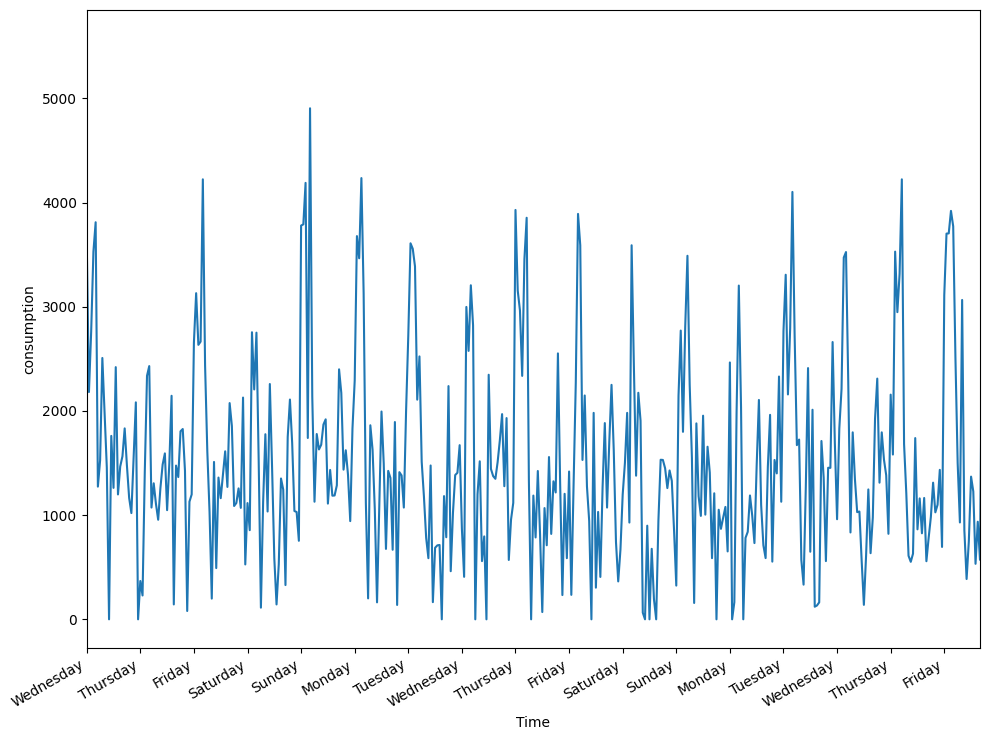

In [15]:
fig, ax = plt.subplots()

ax.plot(df['n_main_consumption'])
ax.set_xlabel('Time')
ax.set_ylabel('consumption')

plt.xticks(np.arange(0, 400, 24), ['Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/test.png', dpi=300)

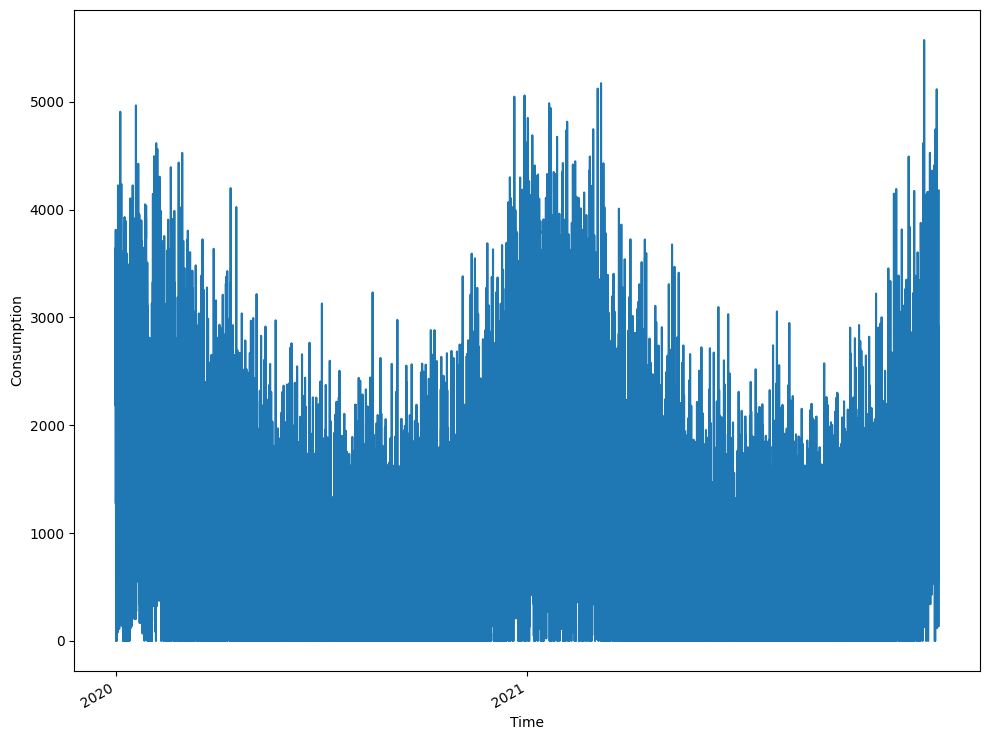

In [16]:
fig, ax = plt.subplots()

ax.plot(df['n_main_consumption'])
ax.set_xlabel('Time')
ax.set_ylabel('Consumption')

plt.xticks([0, 8760], [2020, 2021])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/test-2.png', dpi=300)

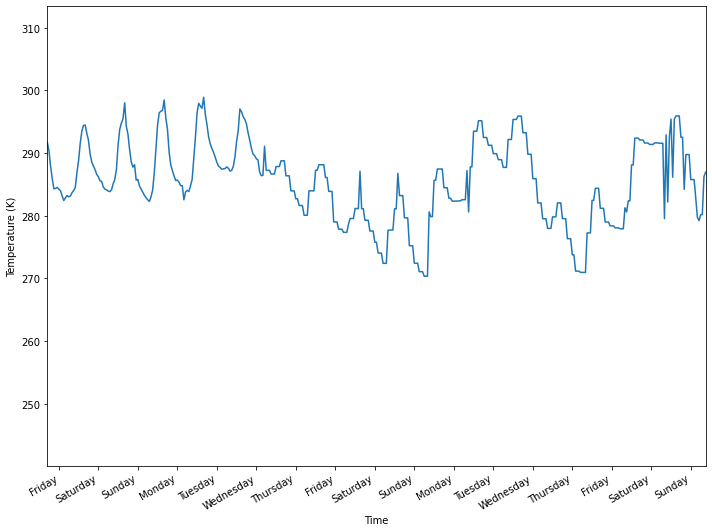

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks(np.arange(7, 400, 24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH12_F06_peixeiro.png', dpi=300)

In [17]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
n_main_generation,17544.0,1144.675103,2236.083666,0.0,0.0,0.0,1246.50,14185.0
n_main_consumption,17544.0,960.434109,903.938398,0.0,206.0,782.0,1434.00,5571.0
n_main_buy,17544.0,833.308767,981.886295,0.0,0.0,507.0,1381.00,5634.0
n_main_sell,17544.0,986.400251,2070.170975,0.0,0.0,0.0,578.75,14010.0
n_main_generated_at_home,17544.0,151.153956,286.073920,0.0,0.0,0.0,196.00,2412.0
n_hems_light,17544.0,226.580939,192.776153,0.0,53.0,203.0,356.00,1428.0
n_hems_air_conditioner,17544.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
n_hems_eco_cute,17544.0,1.056316,28.720764,0.0,0.0,0.0,0.00,1713.0
n_hems_ih,17544.0,73.712152,115.594343,0.0,0.0,17.0,112.00,1351.0
n_hems_fridge,17544.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0


In [ ]:
cols_to_drop = ['rain_1h', 'snow_1h']
df = df.drop(cols_to_drop, axis=1)

df.shape

(17551, 4)

In [18]:
timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)

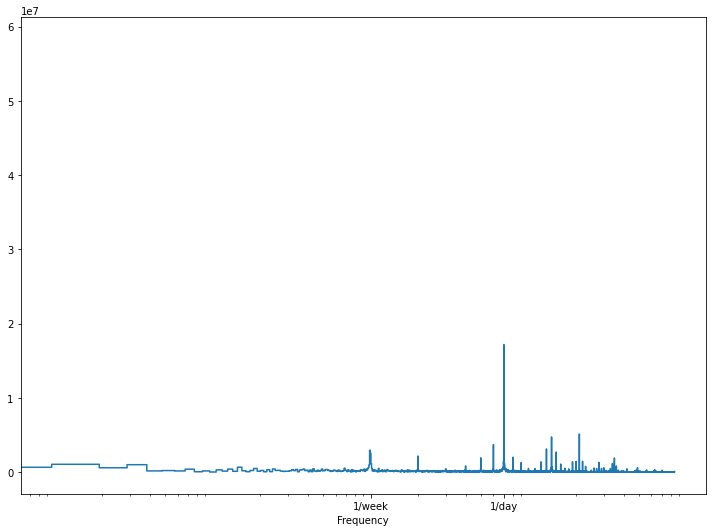

In [ ]:
fft = tf.signal.rfft(df['traffic_volume'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['traffic_volume'])
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week

f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [19]:
day = 24 * 60 * 60

df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

In [20]:
df = df.drop(['date_time'], axis=1)

df.head()

,n_main_generation,n_main_consumption,n_main_buy,n_main_sell,n_main_generated_at_home,n_hems_light,n_hems_air_conditioner,n_hems_eco_cute,n_hems_ih,n_hems_fridge,n_hems_washing,n_hems_ev,day_sin,day_cos
0,0,3638,3533,0,0,94,0,0,158,0,0,1798,-7.670342e-12,1.000000
1,0,2182,3240,0,0,515,0,0,109,0,0,1651,2.588190e-01,0.965926
2,0,2765,1927,0,0,368,0,0,0,0,0,2230,5.000000e-01,0.866025
3,0,3529,3593,0,0,191,0,0,79,0,0,1833,7.071068e-01,0.707107
4,0,3812,3609,0,0,0,0,0,4,0,0,2068,8.660254e-01,0.500000


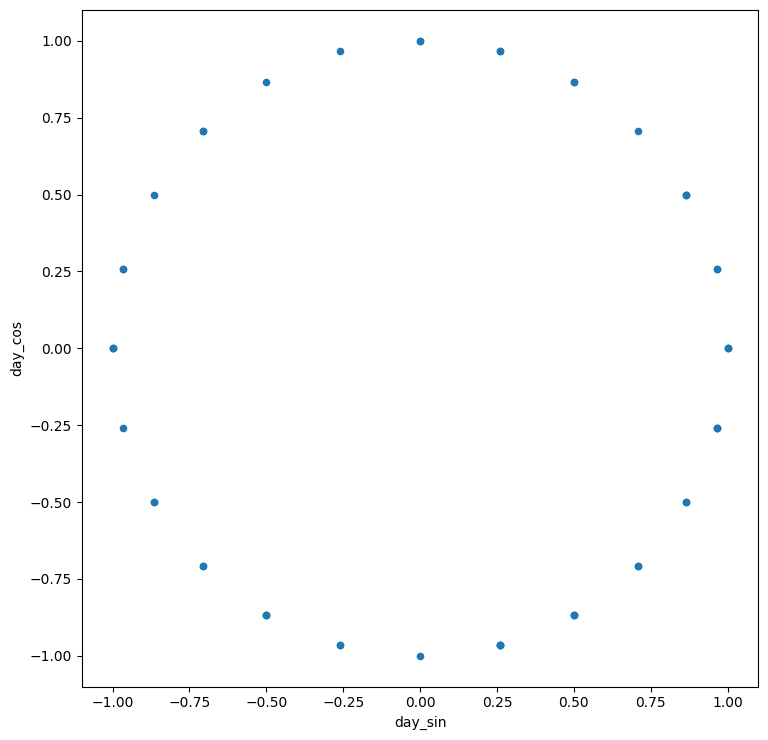

In [21]:
df.sample(50).plot.scatter('day_sin','day_cos').set_aspect('equal');
plt.tight_layout()

plt.savefig('figures/test-3', dpi=300)

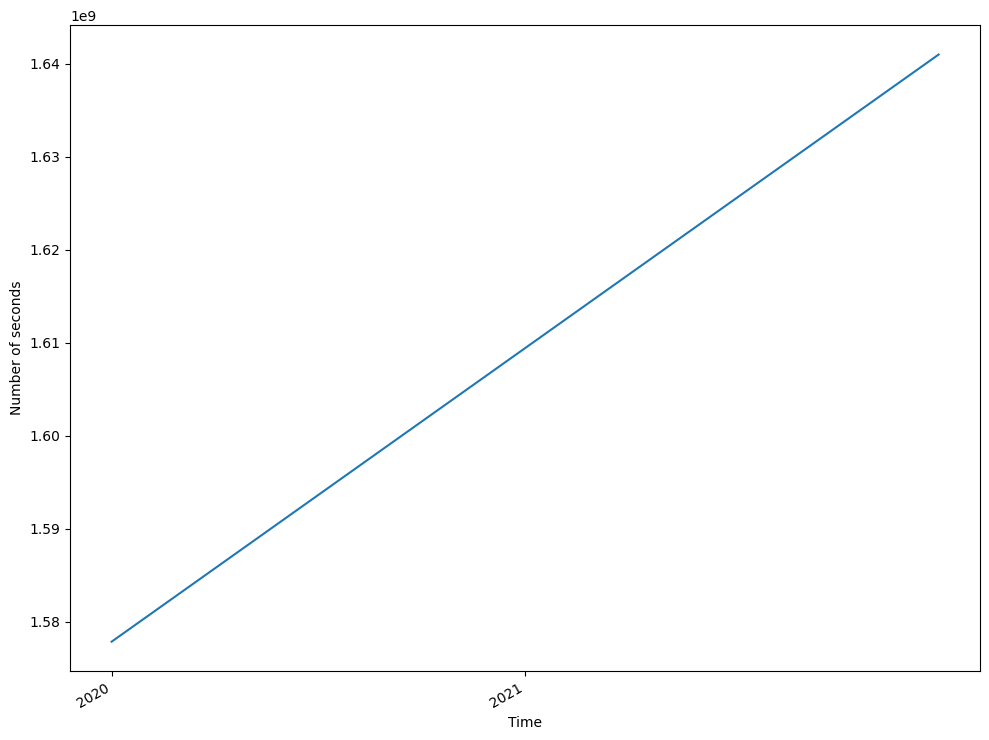

In [22]:
fig, ax = plt.subplots()

ax.plot(timestamp_s)
ax.set_xlabel('Time')
ax.set_ylabel('Number of seconds')

plt.xticks([0, 8760], [2020, 2021])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/test-4.png', dpi=300)

In [23]:
n = len(df)

# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

train_df.shape, val_df.shape, test_df.shape

((12280, 14), (3509, 14), (1755, 14))

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [25]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
n_main_generation,12280.0,0.073740,0.152409,0.0,0.000000,0.000000,0.054283,1.0
n_main_consumption,12280.0,0.197607,0.181088,0.0,0.048347,0.162831,0.294382,1.0
n_main_buy,12280.0,0.160478,0.180315,0.0,0.000000,0.108804,0.265930,1.0
n_main_sell,12280.0,0.064701,0.143123,0.0,0.000000,0.000000,0.000000,1.0
n_main_generated_at_home,12280.0,0.056717,0.113274,0.0,0.000000,0.000000,0.055970,1.0
n_hems_light,12280.0,0.190411,0.166951,0.0,0.034327,0.167118,0.304426,1.0
n_hems_air_conditioner,12280.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
n_hems_eco_cute,12280.0,0.000705,0.018947,0.0,0.000000,0.000000,0.000000,1.0
n_hems_ih,12280.0,0.069923,0.109680,0.0,0.000000,0.015414,0.105010,1.0
n_hems_fridge,12280.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [30]:
train_df.to_csv('data/train.csv')
val_df.to_csv('data/val.csv')
test_df.to_csv('data/test.csv')

OSError: Cannot save file into a non-existent directory: 'data'

In [ ]:
test_df

,temp,clouds_all,traffic_volume,day_sin,day_cos
15795,0.767405,0.90,0.401563,0.500000,1.000000
15796,0.756876,0.90,0.348821,0.629410,0.982963
15797,0.754833,0.90,0.302637,0.750000,0.933013
15798,0.754833,0.90,0.187108,0.853553,0.853553
15799,0.756247,0.90,0.080926,0.933013,0.750000
...,...,...,...,...,...
17546,0.629577,0.75,0.478582,0.370590,0.982963
17547,0.618733,0.90,0.372262,0.500000,1.000000
17548,0.618262,0.90,0.285475,0.629410,0.982963
17549,0.608204,0.90,0.186549,0.750000,0.933013
